In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, KNNWithZScore, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/df_under.csv')
data.head()

,userId,wine,rate
0,91cf68cc-9436-43e1-871d-33beef4d2337,Vistamar Cabernet Sauvignon Reserva,1
1,877019f9-3c77-491d-912e-58b2404aed47,Chianti,1
2,eadb1fb9-7260-4618-aa5a-8f2ebdca2077,Bread & Butter Pinor Noir 2020,1
3,c88644be-2c9b-42f0-9c4b-7f8e81795f43,Terrano,1
4,bc79b0e3-064d-4240-86de-e86499f577e8,2/5 大亂鬥 2,1


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Metric','Optimizer','User_based',
             'RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Metric, Optimizer, User_based, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [3]:
class KnnWithZSore (KNNWithZScore):
    def __init__(self, sim_options={}, bsl_options = {}):
        KNNWithZScore.__init__(self, sim_options=sim_options, bsl_options= bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)
        
    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            KNNWithZScore.fit(self, trainset_fold)
            train_prediction = KNNWithZScore.test(self, trainset_fold.build_testset())
            prediction = KNNWithZScore.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = KNNWithZScore.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        '''Return the k nearest neighbors of user_id'''
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        '''Return the k nearest neighbors of item_id'''
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## KnnWithZScore SGD

* knn_with_zscore cosine, user based

In [4]:
knn_with_zscore = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore.create_reader(data)
predictions = knn_with_zscore.fit()
#acc
metrics = knn_with_zscore.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2611
RMSE: 1.0340
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3093
RMSE: 1.0051
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2699
RMSE: 1.1178
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2799
RMSE: 1.0125
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2773
RMSE: 1.0525
###############################################
The Results are: 

Average RMSE on Training Set: 0.2795106628246027
Average RMSE on Test Set: 1.0443986227941704
RMSE: 1.1330
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.1329901365518698
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.1330
MAE:  0.9502
MSE: 1.2837
Precision: 0.62
Recall: 0.68
the acc is 31.50


/tmp/ipykernel_18781/1944145904.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore cosine, item based

In [5]:
knn_with_zscore2 = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore2.create_reader(data)
predictions = knn_with_zscore2.fit()
#acc
metrics = knn_with_zscore2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2496
RMSE: 1.1531
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3084
RMSE: 1.1087
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2885
RMSE: 1.1227
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2624
RMSE: 1.2342
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3270
RMSE: 1.0792
###############################################
The Results are: 

Average RMSE on Training Set: 0.2871914361356448
Average RMSE on Test Set: 1.1395914271762058
RMSE: 1.0538
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0538196120963415
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.0538
MAE:  0.8740
MSE: 1.1105
Precision: 0.57
Recall: 0.63
the acc is 29.13


/tmp/ipykernel_18781/2949601189.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18781/2949601189.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared difference, user based

In [6]:
knn_with_zscore3 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore3.create_reader(data)
predictions = knn_with_zscore3.fit()
#acc
metrics = knn_with_zscore3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1728
RMSE: 1.0206
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1680
RMSE: 1.1652
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1541
RMSE: 1.1098
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1529
RMSE: 1.0151
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1647
RMSE: 1.0928
###############################################
The Results are: 

Average RMSE on Training Set: 0.16250055540974823
Average RMSE on Test Set: 1.0807039492385577
RMSE: 1.0753
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.07532893583085
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.0753
MAE:  0.8833
MSE: 1.1563
Precision: 0.64
Recall: 0.69
the acc is 33.07


/tmp/ipykernel_18781/2711717971.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18781/2711717971.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared diference, item based

In [7]:
knn_with_zscore4 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore4.create_reader(data)
predictions = knn_with_zscore4.fit()
#acc
metrics = knn_with_zscore4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2224
RMSE: 1.1482
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2557
RMSE: 1.0027
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2471
RMSE: 1.0952
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2386
RMSE: 1.0939
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2189
RMSE: 1.1091
###############################################
The Results are: 

Average RMSE on Training Set: 0.23655222497031655
Average RMSE on Test Set: 1.08980764272988
RMSE: 1.1968
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.1968079199155566
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.1968
MAE:  0.9471
MSE: 1.4323
Precision: 0.72
Recall: 0.76
the acc is 36.22


/tmp/ipykernel_18781/2579909233.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18781/2579909233.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore pearson, user based

In [8]:
knn_with_zscore5 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore5.create_reader(data)
predictions = knn_with_zscore5.fit()
#acc
metrics = knn_with_zscore5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1114
RMSE: 1.1267
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1438
RMSE: 1.1011
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1596
RMSE: 1.0075
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1170
RMSE: 1.0146
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1334
RMSE: 1.0377
###############################################
The Results are: 

Average RMSE on Training Set: 0.1330435690711197
Average RMSE on Test Set: 1.0575178331808215
RMSE: 1.1464
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.1463718306191322
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.1464
MAE:  0.9392
MSE: 1.3142
Precision: 0.66
Recall: 0.71
the acc is 31.50


/tmp/ipykernel_18781/2335934697.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18781/2335934697.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson, item based

In [9]:
knn_with_zscore6 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore6.create_reader(data)
predictions = knn_with_zscore6.fit()
#acc
metrics = knn_with_zscore6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1021
RMSE: 1.0786
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1381
RMSE: 1.1140
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1196
RMSE: 1.1121
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1057
RMSE: 1.0523
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1116
RMSE: 1.1459
###############################################
The Results are: 

Average RMSE on Training Set: 0.11540324221969686
Average RMSE on Test Set: 1.1005890601910884
RMSE: 1.0741
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0741466215865179
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.0741
MAE:  0.8787
MSE: 1.1538
Precision: 0.69
Recall: 0.74
the acc is 33.86


/tmp/ipykernel_18781/3850417117.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18781/3850417117.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, user based

In [10]:
knn_with_zscore7 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore7.create_reader(data)
predictions = knn_with_zscore7.fit()
#acc
metrics = knn_with_zscore7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0826
RMSE: 1.1362
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1627
RMSE: 1.0487
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0733
RMSE: 1.1003
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1595
RMSE: 0.9606
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1681
RMSE: 1.0126
###############################################
The Results are: 

Average RMSE on Training Set: 0.12924358911407993
Average RMSE on Test Set: 1.051693065414137
RMSE: 1.2256
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.225640123254506
Computing the pearson_baseline similarity matrix..

/tmp/ipykernel_18781/2496457707.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18781/2496457707.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, item based

In [11]:
knn_with_zscore8 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore8.create_reader(data)
predictions = knn_with_zscore8.fit()
#acc
metrics = knn_with_zscore8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1791
RMSE: 1.1103
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1601
RMSE: 1.2312
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1212
RMSE: 1.1322
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1739
RMSE: 1.0925
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0675
RMSE: 1.0705
###############################################
The Results are: 

Average RMSE on Training Set: 0.14036453129546908
Average RMSE on Test Set: 1.1273052916497013
RMSE: 1.0368
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0368430554495207
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_18781/1008673265.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18781/1008673265.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


## KnnWithZScore Alternating Least Squares (ALS)

* knn_with_zscore cosine, user based

In [12]:
knn_with_zscore9 = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore9.create_reader(data)
predictions = knn_with_zscore9.fit()
#acc
metrics = knn_with_zscore9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2466
RMSE: 1.0010
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2342
RMSE: 0.9919
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2498
RMSE: 1.0411
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2442
RMSE: 1.0864
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2527
RMSE: 1.0801
###############################################
The Results are: 

Average RMSE on Training Set: 0.24550794278346216
Average RMSE on Test Set: 1.0401100225620301
RMSE: 1.1643
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.1643355556889552
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.1643
MAE:  1.0273
MSE: 1.3557
Precision: 0.60
Recall: 0.67
the acc is 17.32


/tmp/ipykernel_18781/2936597747.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18781/2936597747.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore cosine, item based

In [13]:
knn_with_zscore10 = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore10.create_reader(data)
predictions = knn_with_zscore10.fit()
#acc
metrics = knn_with_zscore10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3166
RMSE: 1.1737
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2905
RMSE: 1.0020
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2811
RMSE: 1.1595
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2558
RMSE: 1.2253
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3024
RMSE: 1.0528
###############################################
The Results are: 

Average RMSE on Training Set: 0.2892771981095136
Average RMSE on Test Set: 1.1226584804593298
RMSE: 1.1201
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.1200658319630639
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.1201
MAE:  0.9423
MSE: 1.2545
Precision: 0.68
Recall: 0.75
the acc is 26.77


/tmp/ipykernel_18781/1654456447.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18781/1654456447.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared difference, user based

In [14]:
knn_with_zscore11 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore11.create_reader(data)
predictions = knn_with_zscore11.fit()
#acc
metrics = knn_with_zscore11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2111
RMSE: 1.0416
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1565
RMSE: 1.1721
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2168
RMSE: 1.0589
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1590
RMSE: 1.0980
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2158
RMSE: 1.0409
###############################################
The Results are: 

Average RMSE on Training Set: 0.19184583448439735
Average RMSE on Test Set: 1.0822891563479338
RMSE: 1.1107
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.1106656361548088
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.1107
MAE:  0.9390
MSE: 1.2336
Precision: 0.66
Recall: 0.77
the acc is 31.50


/tmp/ipykernel_18781/2380454897.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18781/2380454897.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared difference, item based

In [15]:
knn_with_zscore12 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore12.create_reader(data)
predictions = knn_with_zscore12.fit()
#acc
metrics = knn_with_zscore12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2580
RMSE: 1.0494
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2332
RMSE: 1.1930
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2638
RMSE: 1.1193
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3196
RMSE: 1.1665
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3048
RMSE: 1.0887
###############################################
The Results are: 

Average RMSE on Training Set: 0.27588172099097785
Average RMSE on Test Set: 1.1233798081564008
RMSE: 1.0778
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0778058468756064
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0778
MAE:  0.9325
MSE: 1.1617
Precision: 0.68
Recall: 0.71
the acc is 29.92


/tmp/ipykernel_18781/3404645186.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18781/3404645186.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore pearson correlation coefficient, user based

In [16]:
knn_with_zscore13 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore13.create_reader(data)
predictions = knn_with_zscore13.fit()
#acc
metrics = knn_with_zscore13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1170
RMSE: 1.0822
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1880
RMSE: 0.9580
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1854
RMSE: 1.1596
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1191
RMSE: 1.1293
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1813
RMSE: 1.0427
###############################################
The Results are: 

Average RMSE on Training Set: 0.15816367842204854
Average RMSE on Test Set: 1.0743356598554281
RMSE: 1.0798
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0798304918558896
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0798
MAE:  0.9001
MSE: 1.1660
Precision: 0.63
Recall: 0.69
the acc is 33.07


/tmp/ipykernel_18781/1814740321.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18781/1814740321.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore pearson correlation coefficient, item based

In [17]:
knn_with_zscore14 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore14.create_reader(data)
predictions = knn_with_zscore14.fit()
#acc
metrics = knn_with_zscore14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1352
RMSE: 1.1064
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1862
RMSE: 0.8896
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1502
RMSE: 1.1863
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1619
RMSE: 1.1479
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1785
RMSE: 1.1627
###############################################
The Results are: 

Average RMSE on Training Set: 0.16241372817142488
Average RMSE on Test Set: 1.0985653176721708
RMSE: 1.0977
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0977446841630356
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0977
MAE:  0.9285
MSE: 1.2050
Precision: 0.80
Recall: 0.87
the acc is 37.01


/tmp/ipykernel_18781/1740756307.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18781/1740756307.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, user based

In [18]:
knn_with_zscore15 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore15.create_reader(data)
predictions = knn_with_zscore15.fit()
#acc
metrics = knn_with_zscore15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1017
RMSE: 1.1461
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1652
RMSE: 1.0742
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1831
RMSE: 1.0164
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1761
RMSE: 1.0619
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1075
RMSE: 1.1528
###############################################
The Results are: 

Average RMSE on Training Set: 0.14671955391133573
Average RMSE on Test Set: 1.0902787959224063
RMSE: 1.1251
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.1251105871026026
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_18781/2066309904.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18781/2066309904.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, item based

In [19]:
knn_with_zscore16 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore16.create_reader(data)
predictions = knn_with_zscore16.fit()
#acc
metrics = knn_with_zscore16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1588
RMSE: 1.1677
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1614
RMSE: 1.1096
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0788
RMSE: 1.1091
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0863
RMSE: 1.1394
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1534
RMSE: 1.0551
###############################################
The Results are: 

Average RMSE on Training Set: 0.1277646616768132
Average RMSE on Test Set: 1.1161719106729835
RMSE: 1.1406
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.1406462096050511
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_18781/3669178657.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18781/3669178657.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [20]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Metric,Optimizer,User_based,RMSE,MAE,MSE,Precision,Recall,Accuracy
7,8,KnnWithZSore,(shrunk) pearson corr coeff,SGD,False,1.036843,0.838454,1.075044,0.628339,0.675287,32.283465
1,2,KnnWithZSore,Cosine,SGD,False,1.053820,0.873982,1.110536,0.574423,0.626061,29.133858
5,6,KnnWithZSore,pearson corr coeff,SGD,False,1.074147,0.878655,1.153791,0.692925,0.737526,33.858268
2,3,KnnWithZSore,MSD,SGD,True,1.075329,0.883286,1.156332,0.640426,0.693235,33.070866
11,12,KnnWithZSore,MSD,ALS,False,1.077806,0.932534,1.161665,0.675000,0.713558,29.921260
12,13,KnnWithZSore,pearson corr coeff,ALS,True,1.079830,0.900087,1.166034,0.625316,0.690233,33.070866
13,14,KnnWithZSore,pearson corr coeff,ALS,False,1.097745,0.928549,1.205043,0.804646,0.866061,37.007874
10,11,KnnWithZSore,MSD,ALS,True,1.110666,0.938988,1.233578,0.658418,0.770833,31.496063
9,10,KnnWithZSore,Cosine,ALS,False,1.120066,0.942316,1.254547,0.676364,0.747727,26.771654
14,15,KnnWithZSore,(shrunk) pearson corr coeff,ALS,True,1.125111,0.934551,1.265874,0.679006,0.774359,31.496063


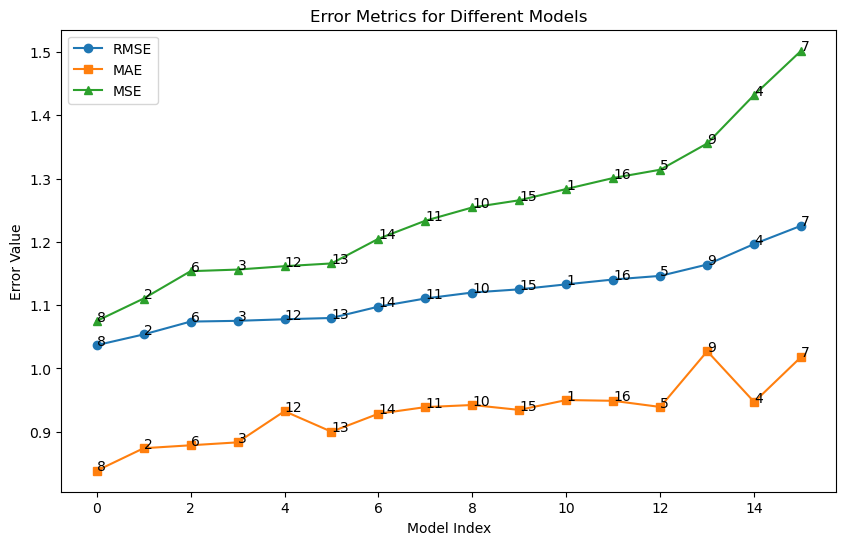

In [21]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

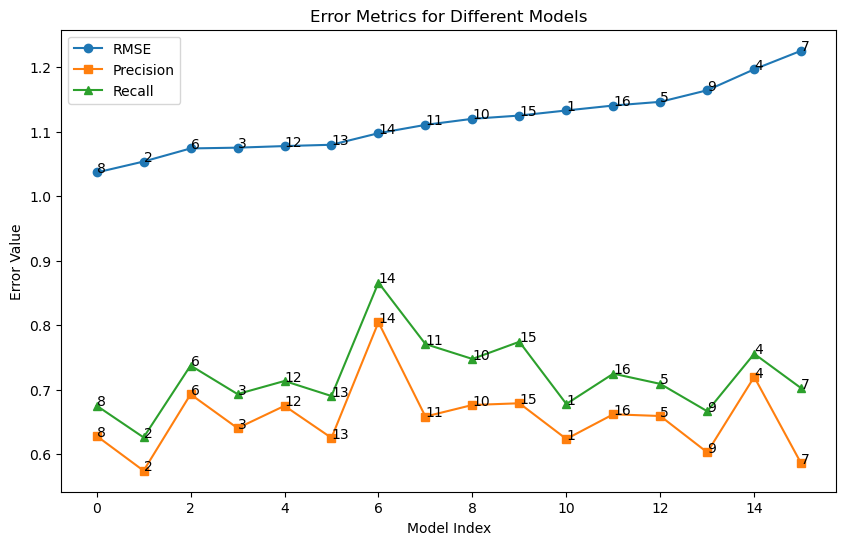

In [22]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

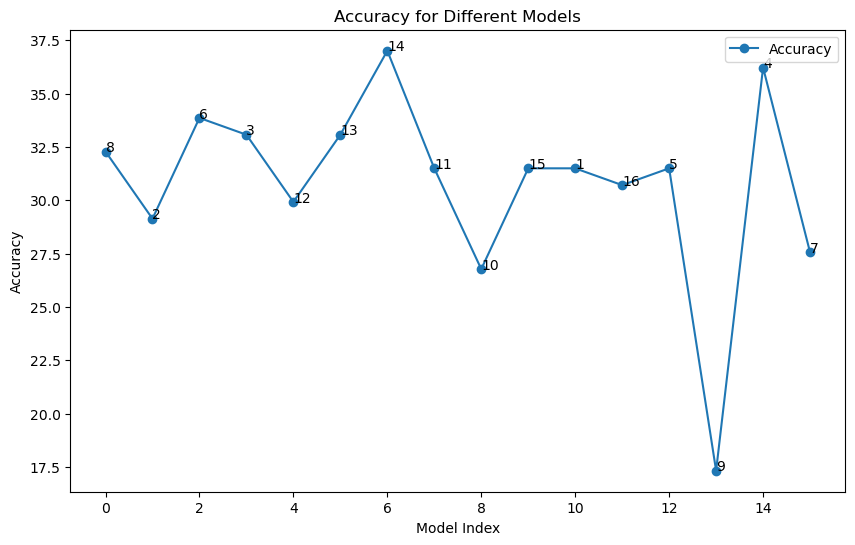

In [23]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [24]:
#recommends items for a given user from predictions

# user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
# top_n = KnnWithMeans.get_top_n_for_user(predictions, user_id)
# print(user_id, [iid for (iid, _) in top_n])
######### better print
user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
top_n = knn_with_zscore.get_top_n_for_user(predictions, user_id)
print(f"Top items for the user '{user_id}' are:")
for i, (iid, _) in enumerate(top_n, 1):
    print(f"{i}. Item ID: {iid}")

Top items for the user '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7' are:
1. Item ID: Lodi California
2. Item ID: Beyerskloof Western Cape
3. Item ID: Fleurie Grand Pre
4. Item ID: Petit Chablis
5. Item ID: Yellow Label 
6. Item ID: Mendoza Chardonnay
7. Item ID: Valle Central Merlot
8. Item ID: Quintessence Montagny 1er Cru
9. Item ID: Valle de Maipo Carmenere


In [25]:
# recommneds users for a given item from predictions

# item_id = 'Chardonnay'
# top_n = KnnWithMeans.get_top_n_users_for_item(predictions, item_id)
# print(item_id, [uid for (uid, _) in top_n])
########## better print
item_id = 'Chardonnay'
top_n = knn_with_zscore.get_top_n_users_for_item(predictions, item_id)
print(f"Top users for the item '{item_id}' are:")
for i, (uid, _) in enumerate(top_n, 1):
    print(f"{i}. User ID: {uid}")

Top users for the item 'Chardonnay' are:
1. User ID: 36fec3ea-e183-491d-b65a-6c7ac90fafa5


In [26]:
#get the KnnWithMeans for a user from the model
knn_with_zscore.get_neighbors_uid(user_id=5)

['5ccd8030-047b-432c-a630-d784ab415756',
 '83128cf9-f07f-4de1-97cf-cbde8d38bc3c',
 '9c85a219-a94e-4b78-b300-ea65e52e9c6e',
 '76b71bb0-6cc9-4168-8a45-bbafc1e9a256',
 '918cd9b7-8057-4106-8f7f-9e9e3a423fb1',
 '47edd867-4e96-411a-b436-970e5f750b03',
 '518f9753-12b1-4987-b651-38944fc33d07',
 '902db46c-a5bf-4d52-acd6-067a2bf3b876',
 '36fec3ea-e183-491d-b65a-6c7ac90fafa5',
 '2c4a4dc1-f355-49c4-b243-cf4fb5683e8e']

In [27]:
#get the KnnWithMeans for an item from the model
knn_with_zscore.get_neighbors_iid(item_id=20)

['Archineri Etna Rosso',
 'Cabernet Sauvignon',
 'Grande reserve',
 'meeker',
 'Vino Nobile di Montepulciano',
 'Domaine Grand Veneur Blanc de Viogier',
 'Vitovska Collection',
 'Chardonnay Biele Zôe Cuvée 85/15',
 'Sauvignon',
 'Grillo Sicilia']

In [28]:
knn_with_zscore.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(knn_with_zscore.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 8 with sim 0.000000000000000
And the baseline estimate is: 3.8586362584868317

#####

Note: If the baseline is 3.6485148514851486 then the value is a default value, Otherwise not


In [29]:
df_pred = knn_with_zscore.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,91cf68cc-9436-43e1-871d-33beef4d2337,Bubbly Pinot Grigio (Champagne),2.0,3.665842,"{'was_impossible': True, 'reason': 'User and/o...",13,0,1.665842
1,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Il mattaglio brut,5.0,5.000000,"{'actual_k': 5, 'was_impossible': False}",61,1,0.000000
2,13016d41-00bd-411c-83f5-2b95691696b7,Pinot Grigio,4.0,2.750000,"{'actual_k': 0, 'was_impossible': False}",11,5,1.250000
3,876b7023-bbf0-4bd8-a341-61ae5bc4b38f,Kerner,4.0,3.665842,"{'was_impossible': True, 'reason': 'User and/o...",2,2,0.334158
4,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Lodi California,2.0,3.665842,"{'was_impossible': True, 'reason': 'User and/o...",16,0,1.665842
5,deb9001b-2e33-42ca-8953-35c11e0ed824,Chianti,4.0,3.665842,"{'was_impossible': True, 'reason': 'User and/o...",1,4,0.334158
6,91cf68cc-9436-43e1-871d-33beef4d2337,Vistamar Cabernet Sauvignon Reserva,1.0,3.665842,"{'was_impossible': True, 'reason': 'User and/o...",13,1,2.665842
7,45a10c93-34ef-4aef-887a-9cd7a4292bec,Vigna Piaggia Brunello di Montalcino,4.0,3.665842,"{'was_impossible': True, 'reason': 'User and/o...",0,0,0.334158
8,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Diablo cabernet Black sauvignon,4.0,3.665842,"{'was_impossible': True, 'reason': 'User and/o...",23,1,0.334158
9,a965be29-83c9-47b7-a5b3-82d99180cf98,Brut Rosé,4.0,3.665842,"{'was_impossible': True, 'reason': 'User and/o...",0,0,0.334158


* best predictions

In [30]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
1,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Il mattaglio brut,5.0,5.000000,"{'actual_k': 5, 'was_impossible': False}",61,1,0.000000
78,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Cabernet Sauvignon,5.0,5.000000,"{'actual_k': 1, 'was_impossible': False}",24,4,0.000000
55,bc79b0e3-064d-4240-86de-e86499f577e8,Terroir de Granit Saint Joseph,5.0,5.000000,"{'actual_k': 1, 'was_impossible': False}",26,1,0.000000
57,bc8f3005-c2c6-4277-9fd7-340248f4e7ec,Franciacorta,5.0,5.000000,"{'actual_k': 1, 'was_impossible': False}",7,2,0.000000
71,a0ef6b50-093e-4ae1-8e3c-58a2a17d2bb8,Cabernet Sauvignon,4.0,4.000000,"{'actual_k': 0, 'was_impossible': False}",3,4,0.000000
70,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Lambrusco Rosè,5.0,5.000000,"{'actual_k': 5, 'was_impossible': False}",61,1,0.000000
62,4a3e010a-0761-48d4-90c1-b2905e0b7b4a,Pinot Noir,3.0,3.000000,"{'actual_k': 0, 'was_impossible': False}",1,4,0.000000
61,09f6ca6e-905f-4afd-bab2-d928fe046f18,Malvasia,4.0,4.250000,"{'actual_k': 0, 'was_impossible': False}",3,4,0.250000
63,d7fffb49-a1f3-433c-a556-a3bc015e7e0f,La Rosina Barbera d'Alba Superiore,4.0,3.665842,"{'was_impossible': True, 'reason': 'User and/o...",1,1,0.334158
107,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Baron amarillo rioja denomacion de origen cali...,4.0,3.665842,"{'was_impossible': True, 'reason': 'User and/o...",23,0,0.334158


* worst predictions

In [31]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
58,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Valle Central Merlot,2.0,3.665842,"{'was_impossible': True, 'reason': 'User and/o...",16,1,1.665842
81,a0ef6b50-093e-4ae1-8e3c-58a2a17d2bb8,Fairbridge,2.0,3.665842,"{'was_impossible': True, 'reason': 'User and/o...",3,0,1.665842
110,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Pinot Nero,3.0,5.000000,"{'actual_k': 0, 'was_impossible': False}",24,1,2.000000
33,bc8f3005-c2c6-4277-9fd7-340248f4e7ec,Franciacorta,3.0,5.000000,"{'actual_k': 1, 'was_impossible': False}",7,2,2.000000
95,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Merlot,2.0,4.333333,"{'actual_k': 0, 'was_impossible': False}",24,3,2.333333
103,bc8f3005-c2c6-4277-9fd7-340248f4e7ec,Bollicina,5.0,2.500000,"{'actual_k': 0, 'was_impossible': False}",7,3,2.500000
39,20e0b694-84a5-4f11-9191-598f924c2947,Morellino di Scansano 2021,1.0,3.665842,"{'was_impossible': True, 'reason': 'User and/o...",1,1,2.665842
114,bf82194f-6108-4524-9cef-69c0231ac74b,Nerello mascalese,1.0,3.665842,"{'was_impossible': True, 'reason': 'User and/o...",0,0,2.665842
56,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Montepulciano 60,1.0,3.665842,"{'was_impossible': True, 'reason': 'User and/o...",61,1,2.665842
6,91cf68cc-9436-43e1-871d-33beef4d2337,Vistamar Cabernet Sauvignon Reserva,1.0,3.665842,"{'was_impossible': True, 'reason': 'User and/o...",13,1,2.665842
